E-Commerce Customer Segmentation & Personalization Engine
==========================================================

Business Context:
- UK-based online retail company specializing in unique gifts
- Operating 2009-2011 with ~1M transactions
- Need: Understand customer segments to personalize marketing

Objective:
Build actionable customer segments using RFM framework and clustering
to enable targeted marketing campaigns and increase customer lifetime value.

Key Questions:
1. What distinct customer types exist in our base?
2. How do segments differ in value, behavior, and risk?
3. What specific actions should marketing take per segment?
4. What's the expected impact on conversion and retention?

Author: Rinkle Fleming
Date: November 2025

In [3]:
# ENVIRONMENT SETUP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import sklearn

# Machine learning 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings('ignore')

# Visualization settings 
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✅ Environment ready")
print(f"📊 Pandas: {pd.__version__}")
print(f"🔢 NumPy: {np.__version__}")
print(f"🤖 Scikit-learn: {sklearn.__version__}")

✅ Environment ready
📊 Pandas: 2.3.3
🔢 NumPy: 2.3.5
🤖 Scikit-learn: 1.7.2


## 1. Data Loading & Initial Assessment

Load the raw transactional data from the Online Retail II dataset and take a first look at:

- Overall volume and time range
- Number of customers and products
- Basic data quality issues

In [22]:
# Load raw data (adjust path if needed)
data_path = "../data/raw/online_retail_II.xlsx"
df = pd.read_excel(data_path, sheet_name="Year 2009-2010")

print("="*70)
print("RAW DATA OVERVIEW")
print("="*70)
print(f"Total rows: {len(df):,}")
print(f"Date range: {df['InvoiceDate'].min()}  →  {df['InvoiceDate'].max()}")
print(f"Unique customers (non-null IDs): {df['Customer ID'].nunique(dropna=True):,}")
print(f"Unique products: {df['StockCode'].nunique():,}")
print(f"Countries: {df['Country'].nunique()}")
df.head()

RAW DATA OVERVIEW
Total rows: 525,461
Date range: 2009-12-01 07:45:00  →  2010-12-09 20:01:00
Unique customers (non-null IDs): 4,383
Unique products: 4,632
Countries: 40


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [23]:
# Basic data quality checks
print("="*70)
print("DATA QUALITY CHECKS")
print("="*70)

missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
quality_df = (
    pd.DataFrame({"Missing_Count": missing, "Missing_Percent": missing_pct})
    .query("Missing_Count > 0")
    .sort_values("Missing_Count", ascending=False)
)

print("\nMissing values:")
print(quality_df)

# Returns (negative quantities)
returns = len(df[df["Quantity"] < 0])
print(f"\nReturns / negative quantities: {returns:,} rows ({returns/len(df)*100:.2f}%)")

# Zero / negative prices
zero_price = len(df[df["Price"] == 0])
neg_price = len(df[df["Price"] < 0])
print(f"Zero-price rows: {zero_price:,}")
print(f"Negative-price rows: {neg_price:,}")

# Cancelled invoices
cancelled = len(df[df["Invoice"].astype(str).str.startswith("C", na=False)])
print(f"Cancelled invoices: {cancelled:,}")

DATA QUALITY CHECKS

Missing values:
             Missing_Count  Missing_Percent
Customer ID         107927        20.539488
Description           2928         0.557225

Returns / negative quantities: 12,326 rows (2.35%)
Zero-price rows: 3,687
Negative-price rows: 3
Cancelled invoices: 10,206


## 2. Data Cleaning

The raw data includes:
- Rows without a customer ID (cannot be used for customer-level analysis)
- Returns and cancellations (negative quantities and cancelled invoices)
- Non-product lines (postage, bank charges, manual adjustments)
- Zero or negative prices

The goal is to keep only valid product purchases that contribute to revenue.

In [24]:
original_size = len(df)
print("🧹 Cleaning data...\n")

# 1. Require a valid customer ID
df_clean = df[df["Customer ID"].notna()].copy()
print(f"✓ Removed {original_size - len(df_clean):,} rows without customer ID")

# 2. Remove returns (negative quantity)
df_clean = df_clean[df_clean["Quantity"] > 0].copy()
print("✓ Removed returns / negative quantities")

# 3. Remove cancelled invoices (Invoice starts with 'C')
df_clean["Invoice"] = df_clean["Invoice"].astype(str)
df_clean = df_clean[~df_clean["Invoice"].str.startswith("C")].copy()
print("✓ Removed cancelled invoices")

# 4. Remove non-product stock codes
df_clean["StockCode"] = df_clean["StockCode"].astype(str)
bad_prefixes = ("POST", "D", "C2", "M", "BANK", "PADS", "DOT")
mask_bad = df_clean["StockCode"].str.startswith(bad_prefixes, na=False)
df_clean = df_clean[~mask_bad].copy()
print("✓ Removed non-product and adjustment codes")

# 5. Remove zero or negative prices
df_clean = df_clean[df_clean["Price"] > 0].copy()
print("✓ Removed rows with zero / negative unit price")

# 6. Compute line revenue
df_clean["TotalPrice"] = df_clean["Quantity"] * df_clean["Price"]

print("\n" + "="*70)
print("CLEANED DATASET")
print("="*70)
print(f"Remaining transactions: {len(df_clean):,} ({len(df_clean)/original_size*100:.1f}% of original)")
print(f"Unique customers: {df_clean['Customer ID'].nunique():,}")
print(f"Date range: {df_clean['InvoiceDate'].min().date()} → {df_clean['InvoiceDate'].max().date()}")
print(f"Total revenue: £{df_clean['TotalPrice'].sum():,.2f}")

df_clean[["Quantity", "InvoiceDate", "Price", "Customer ID", "TotalPrice"]].describe().T


🧹 Cleaning data...

✓ Removed 107,927 rows without customer ID
✓ Removed returns / negative quantities
✓ Removed cancelled invoices
✓ Removed non-product and adjustment codes
✓ Removed rows with zero / negative unit price

CLEANED DATASET
Remaining transactions: 406,342 (77.3% of original)
Unique customers: 4,295
Date range: 2009-12-01 → 2010-12-09
Total revenue: £8,677,893.65


,count,mean,min,25%,50%,75%,max,std
Quantity,406342.0,13.617007,1.0,2.0,5.0,12.0,19152.0,96.994949
InvoiceDate,406342,2010-07-01 09:54:52.122842624,2009-12-01 07:45:00,2010-03-26 14:01:00,2010-07-09 15:31:00,2010-10-14 17:09:00,2010-12-09 20:01:00,NaN
Price,406342.0,3.002049,0.03,1.25,1.95,3.75,387.54,4.533025
Customer ID,406342.0,15373.6077,12346.0,14004.0,15326.0,16814.0,18287.0,1677.402861
TotalPrice,406342.0,21.356133,0.06,4.95,11.85,19.5,15818.4,69.158784


## 3. RFM & Behavioral Features

Next, aggregate the cleaned transactions to the customer level.

For each customer, we calculate:

- **Recency** – days since last purchase
- **Frequency** – number of unique orders
- **Monetary** – total spend
- **ProductDiversity** – number of distinct products purchased
- **AvgOrderValue** – average order value
- **PurchaseSpan** – days between first and last purchase
- **Tenure** – days since first purchase

In [25]:
# Reference date: one day after the last purchase
reference_date = df_clean["InvoiceDate"].max() + timedelta(days=1)
print(f"Reference date for recency calculation: {reference_date.date()}")

# Aggregate to customer level
rfm = df_clean.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (reference_date - x.max()).days,   # Recency
    "Invoice": "nunique",                                       # Frequency (unique orders)
    "TotalPrice": "sum",                                        # Monetary
    "StockCode": "nunique"                                      # Product diversity
}).reset_index()

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary", "ProductDiversity"]

# Average order value
order_counts = df_clean.groupby("Customer ID")["Invoice"].nunique()
total_spend = df_clean.groupby("Customer ID")["TotalPrice"].sum()
rfm["AvgOrderValue"] = rfm["CustomerID"].map(total_spend / order_counts)

# Purchase span and tenure
span = df_clean.groupby("Customer ID")["InvoiceDate"].agg(["min", "max"])
rfm["PurchaseSpan"] = rfm["CustomerID"].map(
    lambda cid: (span.loc[cid, "max"] - span.loc[cid, "min"]).days
)
rfm["Tenure"] = rfm["CustomerID"].map(
    lambda cid: (reference_date - span.loc[cid, "min"]).days
)

print("Customer-level feature set (first 5 rows):")
rfm.head()
print("\nShape:", rfm.shape)

Reference date for recency calculation: 2010-12-10
Customer-level feature set (first 5 rows):

Shape: (4295, 8)


## 4. RFM Scoring

Convert Recency, Frequency, and Monetary into 1–5 scores using quintiles:

- More recent = higher **R_Score**
- More frequent = higher **F_Score**
- Higher spend = higher **M_Score**

Combine these into a three-digit RFM score and assign simple segment labels.


In [26]:
# Quintile-based RFM scores
rfm["R_Score"] = pd.qcut(
    rfm["Recency"],
    q=5,
    labels=[5, 4, 3, 2, 1],
    duplicates="drop"
)

rfm["F_Score"] = pd.qcut(
    rfm["Frequency"].rank(method="first"),
    q=5,
    labels=[1, 2, 3, 4, 5],
    duplicates="drop"
)

rfm["M_Score"] = pd.qcut(
    rfm["Monetary"].rank(method="first"),
    q=5,
    labels=[1, 2, 3, 4, 5],
    duplicates="drop"
)

rfm["RFM_Score"] = (
    rfm["R_Score"].astype(str)
    + rfm["F_Score"].astype(str)
    + rfm["M_Score"].astype(str)
)

def rfm_segment(row):
    r, f, m = int(row["R_Score"]), int(row["F_Score"]), int(row["M_Score"])
    if r >= 4 and f >= 4 and m >= 4:
        return "Champions"
    elif r >= 4 and f >= 3:
        return "Loyal Customers"
    elif r >= 4:
        return "Potential Loyalists"
    elif f >= 4 and m >= 4:
        return "At Risk"
    elif f >= 3 and m >= 3:
        return "Need Attention"
    elif r <= 2 and f <= 2:
        return "Lost"
    else:
        return "Promising"

rfm["Segment_RFM"] = rfm.apply(rfm_segment, axis=1)

print("RFM segment distribution:")
print(rfm["Segment_RFM"].value_counts())
rfm.head()


RFM segment distribution:
Segment_RFM
Lost                   1019
Champions               923
Promising               574
Need Attention          496
Loyal Customers         467
At Risk                 449
Potential Loyalists     367
Name: count, dtype: int64


,CustomerID,Recency,Frequency,Monetary,ProductDiversity,AvgOrderValue,PurchaseSpan,Tenure,R_Score,F_Score,M_Score,RFM_Score,Segment_RFM
0,12346.0,165,11,372.86,26,33.896364,196,361,2,5,2,252,Promising
1,12347.0,3,2,1323.32,70,661.660000,37,40,5,2,4,524,Potential Loyalists
2,12348.0,74,1,221.16,19,221.160000,0,74,2,1,1,211,Lost
3,12349.0,43,2,2221.14,89,1110.570000,181,225,3,2,5,325,Promising
4,12351.0,11,1,300.93,21,300.930000,0,11,5,1,2,512,Potential Loyalists


## 5. RFM Distributions & Correlations

Visualize how Recency, Frequency, Monetary, and the derived segments are distributed across the customer base, and how key features correlate with each other.


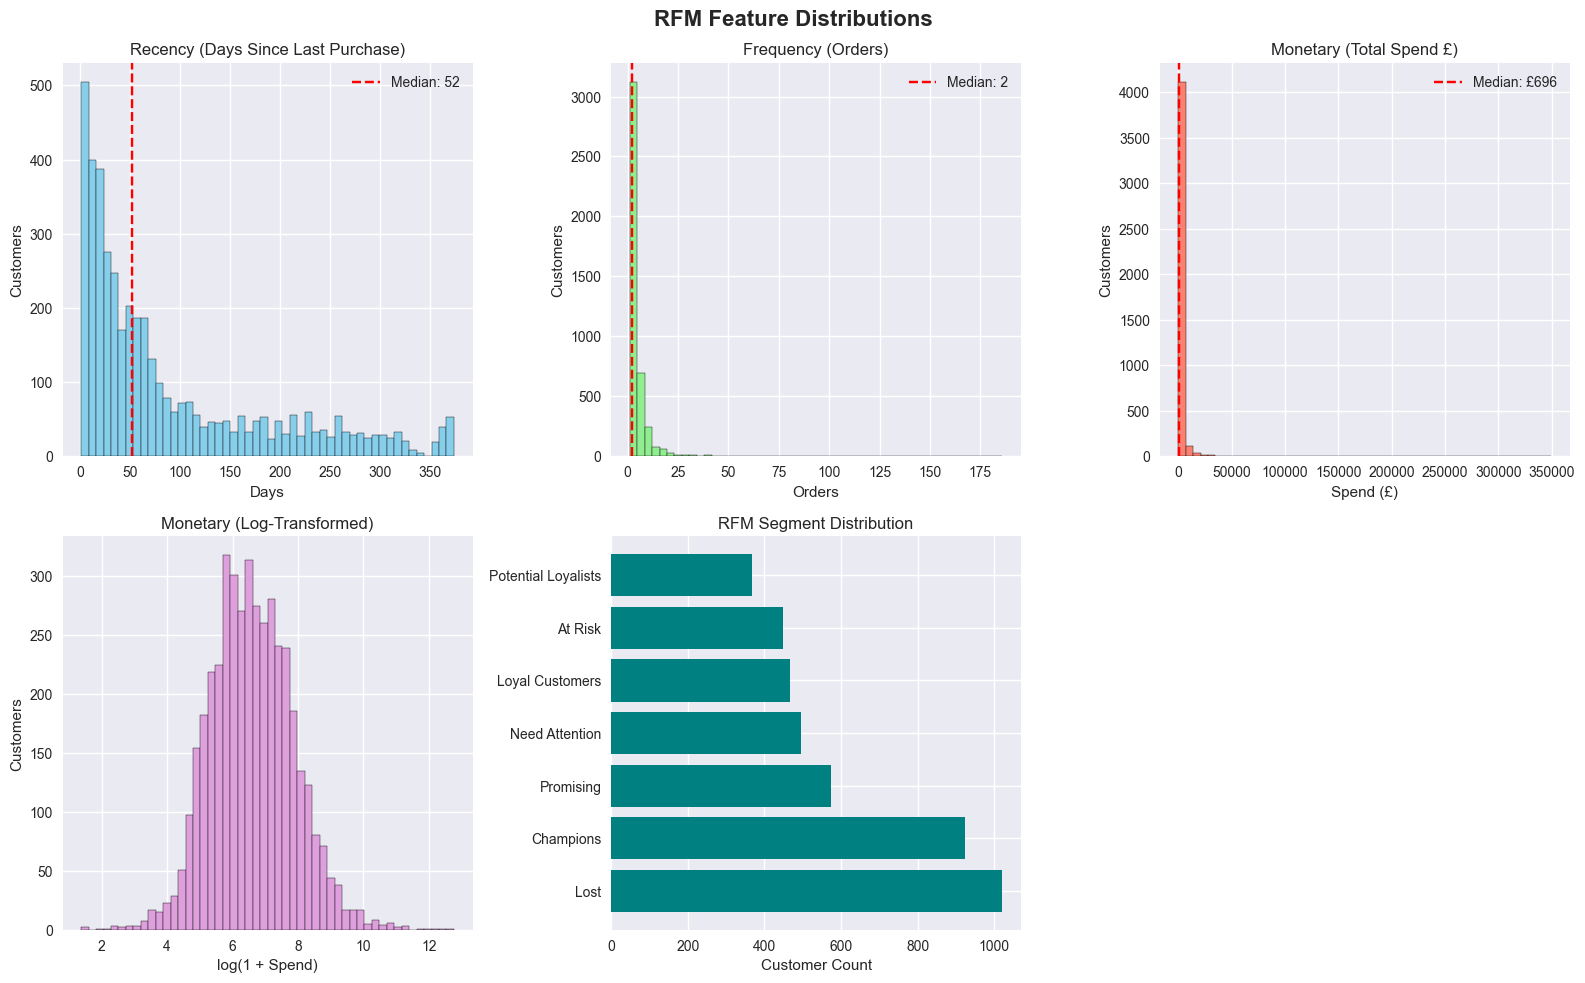

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle("RFM Feature Distributions", fontsize=16, fontweight="bold")

# Recency
axes[0, 0].hist(rfm["Recency"], bins=50, color="skyblue", edgecolor="black")
axes[0, 0].set_title("Recency (Days Since Last Purchase)")
axes[0, 0].set_xlabel("Days")
axes[0, 0].set_ylabel("Customers")
axes[0, 0].axvline(rfm["Recency"].median(), color="red", linestyle="--",
                   label=f"Median: {rfm['Recency'].median():.0f}")
axes[0, 0].legend()

# Frequency
axes[0, 1].hist(rfm["Frequency"], bins=50, color="lightgreen", edgecolor="black")
axes[0, 1].set_title("Frequency (Orders)")
axes[0, 1].set_xlabel("Orders")
axes[0, 1].set_ylabel("Customers")
axes[0, 1].axvline(rfm["Frequency"].median(), color="red", linestyle="--",
                   label=f"Median: {rfm['Frequency'].median():.0f}")
axes[0, 1].legend()

# Monetary
axes[0, 2].hist(rfm["Monetary"], bins=50, color="salmon", edgecolor="black")
axes[0, 2].set_title("Monetary (Total Spend £)")
axes[0, 2].set_xlabel("Spend (£)")
axes[0, 2].set_ylabel("Customers")
axes[0, 2].axvline(rfm["Monetary"].median(), color="red", linestyle="--",
                   label=f"Median: £{rfm['Monetary'].median():.0f}")
axes[0, 2].legend()

# Log Monetary
axes[1, 0].hist(np.log1p(rfm["Monetary"]), bins=50, color="plum", edgecolor="black")
axes[1, 0].set_title("Monetary (Log-Transformed)")
axes[1, 0].set_xlabel("log(1 + Spend)")
axes[1, 0].set_ylabel("Customers")

# Segment distribution
segment_counts = rfm["Segment_RFM"].value_counts()
axes[1, 1].barh(segment_counts.index, segment_counts.values, color="teal")
axes[1, 1].set_title("RFM Segment Distribution")
axes[1, 1].set_xlabel("Customer Count")

axes[1, 2].axis("off")

plt.tight_layout()
plt.show()

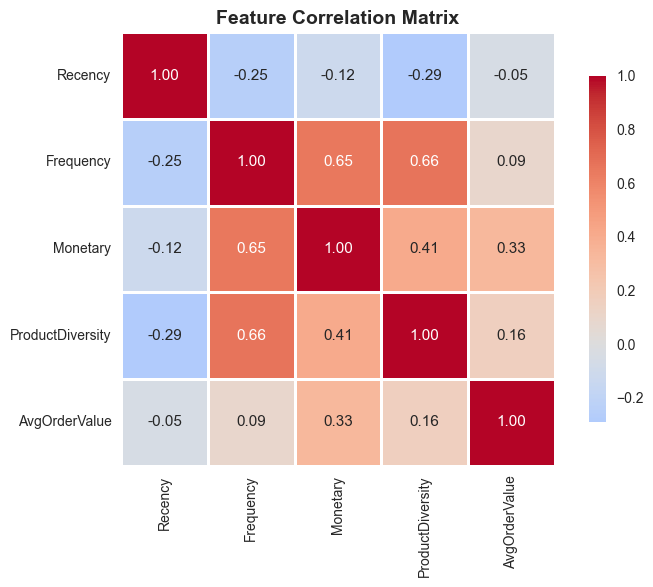

In [28]:
corr_features = ["Recency", "Frequency", "Monetary", "ProductDiversity", "AvgOrderValue"]
corr_matrix = rfm[corr_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title("Feature Correlation Matrix", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


## 6. Outlier Analysis & Clustering Preparation

Before clustering, check for outliers and standardize features so that no single metric dominates.


In [29]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower) | (data[column] > upper)]
    return len(outliers), lower, upper

print("="*70)
print("OUTLIER ANALYSIS")
print("="*70)
for col in ["Recency", "Frequency", "Monetary"]:
    n_outliers, lower, upper = detect_outliers_iqr(rfm, col)
    print(f"\n{col}:")
    print(f"  Outliers: {n_outliers} ({n_outliers/len(rfm)*100:.1f}%)")
    print(f"  IQR range: [{lower:.2f}, {upper:.2f}]")

rfm_cluster = rfm.copy()

# Log-transform skewed measures
for col in ["Recency", "Frequency", "Monetary", "AvgOrderValue"]:
    rfm_cluster[f"{col}_log"] = np.log1p(rfm_cluster[col])

cluster_features = ["Recency_log", "Frequency_log", "Monetary_log", "ProductDiversity", "AvgOrderValue_log"]

X = rfm_cluster[cluster_features].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\n✅ Log transformation and scaling complete.")
print("Feature matrix shape:", X_scaled.shape)


OUTLIER ANALYSIS

Recency:
  Outliers: 177 (4.1%)
  IQR range: [-159.00, 313.00]

Frequency:
  Outliers: 280 (6.5%)
  IQR range: [-5.00, 11.00]

Monetary:
  Outliers: 423 (9.8%)
  IQR range: [-1785.93, 3795.65]

✅ Log transformation and scaling complete.
Feature matrix shape: (4295, 5)


## 7. Choosing the Number of Clusters (K)

Use the elbow method and silhouette scores to pick a reasonable K for K-means.

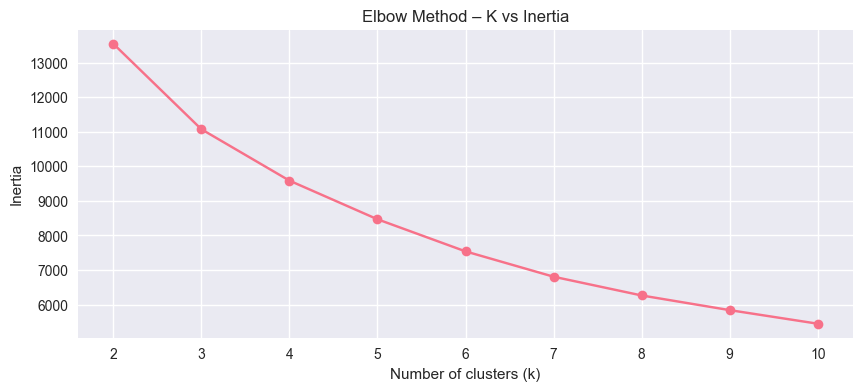

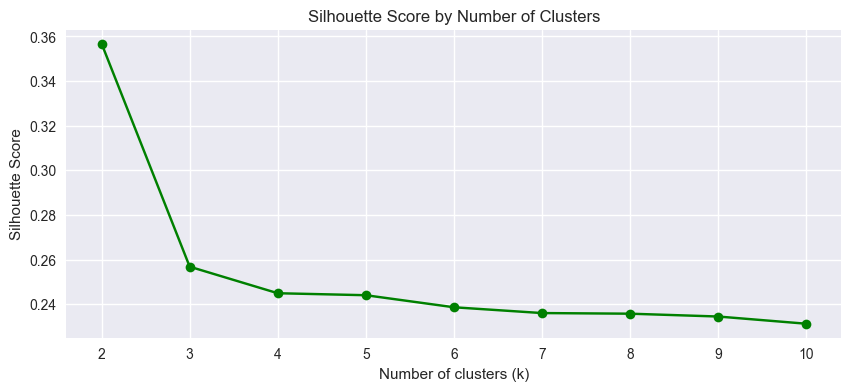

Silhouette scores:
k=2: 0.357
k=3: 0.257
k=4: 0.245
k=5: 0.244
k=6: 0.239
k=7: 0.236
k=8: 0.236
k=9: 0.234
k=10: 0.231


In [30]:
K_range = range(2, 11)

inertias = []
sil_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(10, 4))
plt.plot(K_range, inertias, marker="o")
plt.title("Elbow Method – K vs Inertia")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.xticks(K_range)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(K_range, sil_scores, marker="o", color="green")
plt.title("Silhouette Score by Number of Clusters")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(K_range)
plt.grid(True)
plt.show()

print("Silhouette scores:")
for k, s in zip(K_range, sil_scores):
    print(f"k={k}: {s:.3f}")


## 8. Final K-means Model & Cluster Profiling

Select K based on the plots above (for example, K = 5), fit the final model, and profile each cluster.


In [31]:
optimal_k = 5  # adjust after you review the plots

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=50)
rfm_cluster["Cluster"] = kmeans_final.fit_predict(X_scaled)

print("Cluster sizes:")
print(rfm_cluster["Cluster"].value_counts().sort_index())

Cluster sizes:
Cluster
0     971
1     966
2    1008
3     120
4    1230
Name: count, dtype: int64


In [32]:
cluster_profile = rfm_cluster.groupby("Cluster").agg({
    "CustomerID": "nunique",
    "Recency": ["mean", "median"],
    "Frequency": ["mean", "median"],
    "Monetary": ["mean", "median"],
    "ProductDiversity": ["mean", "median"],
    "AvgOrderValue": ["mean", "median"],
    "PurchaseSpan": ["mean", "median"],
    "Tenure": ["mean", "median"]
})

cluster_profile.columns = ["_".join(col).strip() for col in cluster_profile.columns.values]
cluster_profile = cluster_profile.sort_values("Monetary_mean", ascending=False)
cluster_profile


,CustomerID_nunique,Recency_mean,Recency_median,Frequency_mean,Frequency_median,Monetary_mean,Monetary_median,ProductDiversity_mean,ProductDiversity_median,AvgOrderValue_mean,AvgOrderValue_median,PurchaseSpan_mean,PurchaseSpan_median,Tenure_mean,Tenure_median
Cluster,,,,,,,,,,,,,,,
3,120,15.116667,7.0,29.600000,18.5,20703.826000,7573.275,389.625000,341.0,592.102083,435.134643,330.016667,357.0,345.666667,368.5
0,971,29.024717,17.0,8.829042,7.0,4238.454284,2712.850,118.860968,109.0,513.976365,373.904286,270.693100,291.0,300.209063,325.0
4,1230,137.153659,106.0,1.970732,2.0,984.988894,714.985,42.171545,34.0,538.600174,397.825000,75.230081,18.5,212.638211,229.0
2,1008,27.169643,21.0,3.058532,3.0,680.578611,620.495,44.344246,38.0,239.289615,225.040000,151.725198,154.0,179.297619,186.0
1,966,170.901656,163.0,1.427536,1.0,186.683064,169.105,15.666667,11.0,140.132293,136.495000,29.327122,0.0,200.364389,207.0


## 9. Map Clusters to Human-Readable Segment Names

Translate the numeric clusters into intuitive segment labels that marketing teams can work with.


In [33]:
# Example mapping – adjust after reviewing cluster_profile
segment_map = {
    0: "High-Value Loyalists",
    1: "Growth Potential",
    2: "Price-Sensitive Regulars",
    3: "One-Time Seasonal",
    4: "At-Risk / Dormant"
}

rfm_cluster["SegmentName"] = rfm_cluster["Cluster"].map(segment_map)

rfm_cluster[["CustomerID", "Cluster", "SegmentName"]].head()

,CustomerID,Cluster,SegmentName
0,12346.0,1,Growth Potential
1,12347.0,2,Price-Sensitive Regulars
2,12348.0,1,Growth Potential
3,12349.0,4,At-Risk / Dormant
4,12351.0,2,Price-Sensitive Regulars


## 10. Export Customer Segments for Tableau

Export a clean, customer-level table that can be used for building an interactive Tableau dashboard.

In [34]:
export_cols = [
    "CustomerID", "Recency", "Frequency", "Monetary",
    "ProductDiversity", "AvgOrderValue", "PurchaseSpan", "Tenure",
    "Cluster", "SegmentName"
]

rfm_export = rfm_cluster[export_cols].copy()
rfm_export.to_csv("../data/processed/customer_segments.csv", index=False)

print("✅ Exported '../data/processed/customer_segments.csv' for Tableau.")
print("Rows:", len(rfm_export))


✅ Exported '../data/processed/customer_segments.csv' for Tableau.
Rows: 4295


## 11. Summary of Findings & Business Recommendations

This project analyzed one year of transaction data from a UK-based online retailer and produced a set of actionable customer segments.

**What was done**
- Cleaned raw invoice-level data by removing invalid rows (missing customer IDs, returns, cancellations, non-product lines, zero/negative prices).
- Aggregated behavior to the customer level and engineered RFM + behavioral features:
  - Recency, Frequency, Monetary
  - Product diversity
  - Average order value
  - Purchase span and tenure
- Built quintile-based RFM scores and created intuitive rule-based segments (Champions, Loyal Customers, At Risk, Lost, etc.).
- Standardized features and used K-means clustering to identify data-driven customer segments.
- Profiled each cluster by value and behavior and exported a customer-level segment file for Tableau.

**Key customer segments (example)**
- **High-Value Loyalists** – long-tenured, frequent purchasers with high monetary value and broad product engagement.
- **Growth Potential** – relatively recent customers with strong spend but shorter tenure; good candidates for loyalty-building offers.
- **Price-Sensitive Regulars** – steady order frequency with lower average order value; respond better to discounts and bundles.
- **One-Time Seasonal** – customers with a narrow purchase window and limited span; relevant around specific holidays or campaigns.
- **At-Risk / Dormant** – historically valuable but now inactive; should be targeted with win-back campaigns.

**Recommended actions (at a high level)**
- Invest in retention and exclusivity perks for High-Value Loyalists (early access, VIP offers, tailored recommendations).
- Nurture Growth Potential customers with onboarding journeys and personalized suggestions to increase frequency.
- Use targeted promotions and value bundles for Price-Sensitive Regulars to raise average order value.
- Run seasonal reminder campaigns for One-Time Seasonal customers aligned with their historical purchase period.
- Test win-back incentives and re-engagement emails for At-Risk / Dormant customers and monitor uplift.

This segmentation can be operationalized by integrating the exported segment file into CRM and marketing platforms and by monitoring segment-level KPIs in the Tableau dashboard.
